<a href="https://colab.research.google.com/github/DenA054/stanfproj/blob/main/CS68_ML_for_Biz_Denis_Azarov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import datetime
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn import preprocessing

#Data import

In [ ]:
!pip install opendatasets --upgrade

import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents?datasetId=199387&searchQuery=regression'
od.download(dataset_url)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Skipping, found downloaded files in "./us-accidents" (use force=True to force download)


In [ ]:
df_org=pd.read_csv('/content/us-accidents/US_Accidents_Dec21_updated.csv')
df_org.dropna(inplace=True) # Dropping NANs

In [ ]:
#filter the data to exclude years of COVID-19
df_org = df_org[df_org['Start_Time'].str.startswith(('2016','2017','2018','2019'))]

# Number of Accidents in Los Angeles Regression

In [ ]:
#filter the cities to only include LA to reduce dataset on size
df_LA = df_org[df_org['City'] == 'Los Angeles']

#Missing Weather Data

In [ ]:
# One of the few NCEI weather stations in CA that tracks WT01 & WT08 weather Types - Fog, ice fog, smoke and haze
weather_data_LA  = pd.read_csv('https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&dataTypes=TMAX&dataTypes=TMIN&dataTypes=PRCP&dataTypes=WT08&dataTypes=AWND&dataTypes=WT01&stations=USW00093134&startDate=2017-01-01&endDate=2019-12-31&units=standard&format=csv&token=mGUGnIjKAlLqGSkTOagbLkuQaILeMSEj')

#Merge

In [ ]:
# Extract day from the start_time column
df_LA['Start_Time'] = pd.to_datetime(df_LA['Start_Time'])
df_LA['day'] = df_LA['Start_Time'].dt.day
df_LA['month'] = df_LA['Start_Time'].dt.month
df_LA['year'] = df_LA['Start_Time'].dt.year
df_LA['year_month_day'] = df_LA['year'].astype(str) + '-' + df_LA['month'].astype(str)+ '-' + df_LA['day'].astype(str)

<ipython-input-435-281d99e2b003>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LA['Start_Time'] = pd.to_datetime(df_LA['Start_Time'])
<ipython-input-435-281d99e2b003>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LA['day'] = df_LA['Start_Time'].dt.day
<ipython-input-435-281d99e2b003>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [ ]:
df_LA['year_month_day']

2357355    2019-12-31
2363537    2019-12-22
2363563    2019-12-22
2363581    2019-12-22
2363654    2019-12-22
              ...    
2837594      2019-8-6
2838091      2019-8-7
2840707     2019-8-13
2842333     2019-8-16
2843308     2019-8-19
Name: year_month_day, Length: 1920, dtype: object

In [ ]:
# Group the data by day
grouped_data = df_LA.groupby(by=['year_month_day'])

# Calculate the number of accidents per day
accidents_per_day = grouped_data['ID'].count()

In [ ]:
accidents_per_day

year_month_day
2019-10-1     16
2019-10-10    18
2019-10-11    14
2019-10-12    19
2019-10-13    15
              ..
2019-9-5      12
2019-9-6      16
2019-9-7      17
2019-9-8       8
2019-9-9      11
Name: ID, Length: 172, dtype: int64

In [ ]:
# merge dataset to include weather for every day of the period under consideration
merged_dataset = pd.merge(accidents_per_day, weather_data_LA, how='right', left_on=['year_month_day'], right_on=['DATE'])

In [ ]:
merged_dataset.head()

,ID,STATION,DATE,AWND,PRCP,TMAX,TMIN,WT01,WT08
0,NaN,USW00093134,2017-01-01,1.12,0.00,62,43,1.0,1.0
1,NaN,USW00093134,2017-01-02,1.79,0.00,58,51,NaN,NaN
2,NaN,USW00093134,2017-01-03,0.00,0.00,60,48,NaN,NaN
3,NaN,USW00093134,2017-01-04,1.12,0.03,63,47,1.0,1.0
4,NaN,USW00093134,2017-01-05,3.80,0.39,65,54,1.0,NaN


In [ ]:
merged_dataset.rename(columns = {'ID': 'accidents_per_day'}, inplace = True) 

In [ ]:
# replace nans with 0 for days without accidents and days without WT01 weather events
df_mrg=merged_dataset.replace(np.nan,0) 

In [ ]:
df_mrg.head()

,accidents_per_day,STATION,DATE,AWND,PRCP,TMAX,TMIN,WT01,WT08
0,0.0,USW00093134,2017-01-01,1.12,0.00,62,43,1.0,1.0
1,0.0,USW00093134,2017-01-02,1.79,0.00,58,51,0.0,0.0
2,0.0,USW00093134,2017-01-03,0.00,0.00,60,48,0.0,0.0
3,0.0,USW00093134,2017-01-04,1.12,0.03,63,47,1.0,1.0
4,0.0,USW00093134,2017-01-05,3.80,0.39,65,54,1.0,0.0


In [ ]:
#assign variables for the regression
y=df_mrg['accidents_per_day']

X=df_mrg['TMAX']

t=df_mrg['DATE']

In [ ]:
y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
1090    12.0
1091     7.0
1092    14.0
1093    13.0
1094    13.0
Name: accidents_per_day, Length: 1095, dtype: float64

In [ ]:
X

0       62
1       58
2       60
3       63
4       65
        ..
1090    66
1091    64
1092    63
1093    66
1094    75
Name: TMAX, Length: 1095, dtype: int64

In [ ]:
t

0       2017-01-01
1       2017-01-02
2       2017-01-03
3       2017-01-04
4       2017-01-05
           ...    
1090    2019-12-27
1091    2019-12-28
1092    2019-12-29
1093    2019-12-30
1094    2019-12-31
Name: DATE, Length: 1095, dtype: object

#Regression Model

In [ ]:
#Assign independent variables

TMIN=df_mrg['TMIN']
WT01=df_mrg['WT01']
WT08=df_mrg['WT08']
PRCP=df_mrg['PRCP']

X=pd.DataFrame({'TMIN':TMIN, 'PRCP':PRCP, 'Fog':WT01, 'Smoke_haze':WT08})

In [ ]:
# adding constant
X = sm.add_constant(X)
X.head()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,TMIN,PRCP,Fog,Smoke_haze
0,1.0,43,0.00,1.0,1.0
1,1.0,51,0.00,0.0,0.0
2,1.0,48,0.00,0.0,0.0
3,1.0,47,0.03,1.0,1.0
4,1.0,54,0.39,1.0,0.0


In [ ]:
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      accidents_per_day   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     5.500
Date:                Thu, 16 Feb 2023   Prob (F-statistic):           0.000220
Time:                        00:06:42   Log-Likelihood:                -2931.8
No. Observations:                1095   AIC:                             5874.
Df Residuals:                    1090   BIC:                             5899.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8304      0.856      3.307      0.0

# Severity Prediction for California

In [ ]:
#filter the states to only include California
df_ca = df_org[df_org['State'] == 'CA']

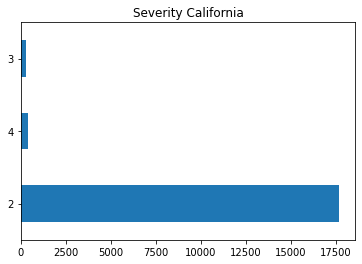

In [ ]:
df_ca.Severity.value_counts().plot(kind='barh', title='Severity California')
plt.show() 

In [ ]:
# Removing features with no information content / less important features
del df_ca['ID'] 
#del df_ca['Start_Time']
del df_ca['End_Time']
#del df_ca['City']
del df_ca['End_Lat']
del df_ca['End_Lng']
del df_ca['Description']
del df_ca['Number']
del df_ca['Street']
del df_ca['Side']
del df_ca['County']
del df_ca['State']
del df_ca['Country']
del df_ca['Timezone']
del df_ca['Airport_Code']
del df_ca['Weather_Timestamp']
del df_ca['Civil_Twilight']
del df_ca['Nautical_Twilight']
del df_ca['Astronomical_Twilight']
del df_ca['Turning_Loop']
del df_ca['Zipcode']
del df_ca['Station']
del df_ca['Distance(mi)']

In [ ]:
# Converting Start_Time to a usable data format
Start_Time_int = []

#Loop through each value in the Start_Time variable
for value in df_ca['Start_Time']:
    #Split the string to remove the '.000000000'
    value_split = value.split('.')
    #Convert the value to a datetime object
    datetime_object = datetime.datetime.strptime(value_split[0], '%Y-%m-%d %H:%M:%S')
    #Add the unix timestamp of the datetime object to the new list
    Start_Time_int.append(datetime_object.timestamp())

#Replace the Start_Time variable with the new list of transformed values
df_ca['Start_Time'] = Start_Time_int

<ipython-input-454-919af3d9fb9c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['Start_Time'] = Start_Time_int


In [ ]:
df_ca.head()

,Severity,Start_Time,Start_Lat,Start_Lng,City,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),...,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset
2408,2,1.461330e+09,38.84685,-120.02881,South Lake Tahoe,33.1,27.7,92.0,29.77,0.5,...,False,False,False,False,False,False,False,False,False,Day
2476,2,1.461513e+09,38.82653,-120.03011,Echo Lake,46.0,43.1,54.0,29.87,10.0,...,False,False,False,False,False,False,False,False,False,Day
3092,2,1.462799e+09,35.52718,-121.04482,Cambria,71.0,71.0,53.0,29.75,10.0,...,False,False,False,False,False,False,False,False,False,Day
3928,4,1.464193e+09,35.69116,-121.28950,Ragged Point,66.0,66.0,59.0,29.90,10.0,...,False,False,False,False,False,False,False,False,False,Day
4603,4,1.465236e+09,35.72088,-118.49953,Wofford Heights,101.0,101.0,8.0,27.28,10.0,...,False,False,False,False,False,False,False,False,False,Day


In [ ]:
print('Number of NAN values: {}'.format(df_SF.Severity.isna().sum()))

Number of NAN values: 0


In [ ]:
df_ca.Sunrise_Sunset = df_ca.Sunrise_Sunset.replace({'Day':1, 'Night':0}) # Replacing 'Day' and 'Night' with numerical values

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


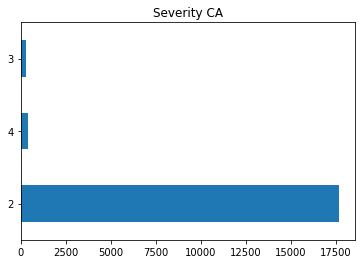

In [ ]:
df_ca.Severity.value_counts().plot(kind='barh', title='Severity CA')
plt.show() 

In [ ]:
df_ca.Severity = df_ca.Severity.replace({1:0, 2:0, 3:1, 4:1}) # reducing Severity index

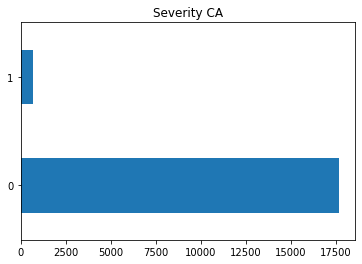

In [ ]:
df_ca.Severity.value_counts().plot(kind='barh', title='Severity CA')
plt.show()

In [ ]:
df_ca.Severity.value_counts()

0    17707
1      708
Name: Severity, dtype: int64

# Dealing with Unbalanced Data

In [ ]:
positive_labels = df_ca[df_ca.Severity==1]
num_positive_labels = positive_labels.shape[0]
num_positive_labels

708

In [ ]:
negative_labels = df_ca[df_ca.Severity==0].sample(num_positive_labels)
negative_labels.shape

(708, 26)

In [ ]:
df_ca_bal =  positive_labels.append(negative_labels)
df_ca_bal.Severity.value_counts()

1    708
0    708
Name: Severity, dtype: int64

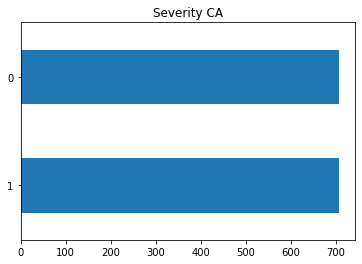

In [ ]:
df_ca_bal.Severity.value_counts().plot(kind='barh', title='Severity CA')
plt.show()

# ML Models

In [ ]:
y = df_ca_bal.pop('Severity') # Removing Severity field and storing it in variable y

In [ ]:
categorical_cols = df_ca_bal.columns[df_ca_bal.dtypes=='object'].tolist()
categorical_cols

['City', 'Wind_Direction', 'Weather_Condition']

In [ ]:
# Create dummy variables
df_ca_bal = pd.get_dummies(data = df_ca_bal, columns=categorical_cols, drop_first=False)
df_ca_bal

,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Weather_Condition_Mostly Cloudy,Weather_Condition_Mostly Cloudy / Windy,Weather_Condition_Overcast,Weather_Condition_Partly Cloudy,Weather_Condition_Partly Cloudy / Windy,Weather_Condition_Rain,Weather_Condition_Rain / Windy,Weather_Condition_Smoke,Weather_Condition_Snow,Weather_Condition_T-Storm
3928,1.464193e+09,35.691160,-121.289500,66.0,66.0,59.0,29.90,10.0,20.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4603,1.465236e+09,35.720880,-118.499530,101.0,101.0,8.0,27.28,10.0,18.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4604,1.465236e+09,35.720930,-118.499920,101.0,101.0,8.0,27.28,10.0,18.0,0.0,...,0,0,0,1,0,0,0,0,0,0
6582,1.460562e+09,34.436780,-118.372328,74.0,74.0,48.0,29.14,10.0,9.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6584,1.460562e+09,34.432644,-118.383992,74.0,74.0,48.0,29.14,10.0,9.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2481291,1.567421e+09,38.502312,-121.432019,82.0,82.0,44.0,29.90,10.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2420025,1.571252e+09,38.591279,-121.479478,65.0,65.0,50.0,29.82,10.0,8.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2414288,1.570775e+09,34.521978,-118.097385,41.0,41.0,20.0,27.48,10.0,3.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2435050,1.572160e+09,35.376234,-118.914164,53.0,53.0,57.0,29.21,10.0,13.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X=df_ca_bal

In [ ]:
print(X.columns.tolist())

['Start_Time', 'Start_Lat', 'Start_Lng', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'City_Agoura Hills', 'City_Albion', 'City_Alhambra', 'City_Alturas', 'City_American Canyon', 'City_Anaheim', 'City_Angels Camp', 'City_Antioch', 'City_Aptos', 'City_Arbuckle', 'City_Arnold', 'City_Aromas', 'City_Arroyo Grande', 'City_Arvin', 'City_Auburn', 'City_Azusa', 'City_Bakersfield', 'City_Baldwin Park', 'City_Bay Point', 'City_Beaumont', 'City_Bell Gardens', 'City_Bella Vista', 'City_Bellflower', 'City_Belmont', 'City_Belvedere Tiburon', 'City_Ben Lomond', 'City_Berkeley', 'City_Big Pine', 'City_Big Sur', 'City_Bishop', 'City_Bloomington', 'City_Blue Lake', 'City_Blythe', 'City_Bodega', 'City_Bodega Bay', 'City_Boron', 'City_Boulder Creek', 'City_Brentwood', 'City_B

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25)

In [ ]:
X_train.head()

,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Weather_Condition_Mostly Cloudy,Weather_Condition_Mostly Cloudy / Windy,Weather_Condition_Overcast,Weather_Condition_Partly Cloudy,Weather_Condition_Partly Cloudy / Windy,Weather_Condition_Rain,Weather_Condition_Rain / Windy,Weather_Condition_Smoke,Weather_Condition_Snow,Weather_Condition_T-Storm
2368679,1.577455e+09,35.036520,-120.182570,60.0,60.0,38.0,29.70,10.0,14.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2797712,1.559080e+09,32.764630,-117.161680,58.0,58.0,81.0,29.48,10.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2495046,1.568406e+09,34.033532,-118.137931,77.0,77.0,64.0,29.66,10.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2482485,1.567532e+09,41.420057,-122.383385,79.0,79.0,19.0,26.38,10.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2409116,1.570483e+09,35.653261,-121.221257,56.0,56.0,80.0,29.70,10.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()  

print(rf_model)

rf_model.fit(X_train, y_train)  
pred_rf = rf_model.predict_proba(X_test)[:,1]

RandomForestClassifier()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_rf.round(0)))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       183
           1       0.90      0.84      0.87       171

    accuracy                           0.88       354
   macro avg       0.88      0.87      0.88       354
weighted avg       0.88      0.88      0.88       354



In [ ]:
from xgboost import XGBClassifier
from xgboost import plot_importance

xgb_model = XGBClassifier()

print(xgb_model)

xgb_model.fit(X_train, y_train)
pred_xgb =  xgb_model.predict_proba(X_test)[:, 1]

XGBClassifier()


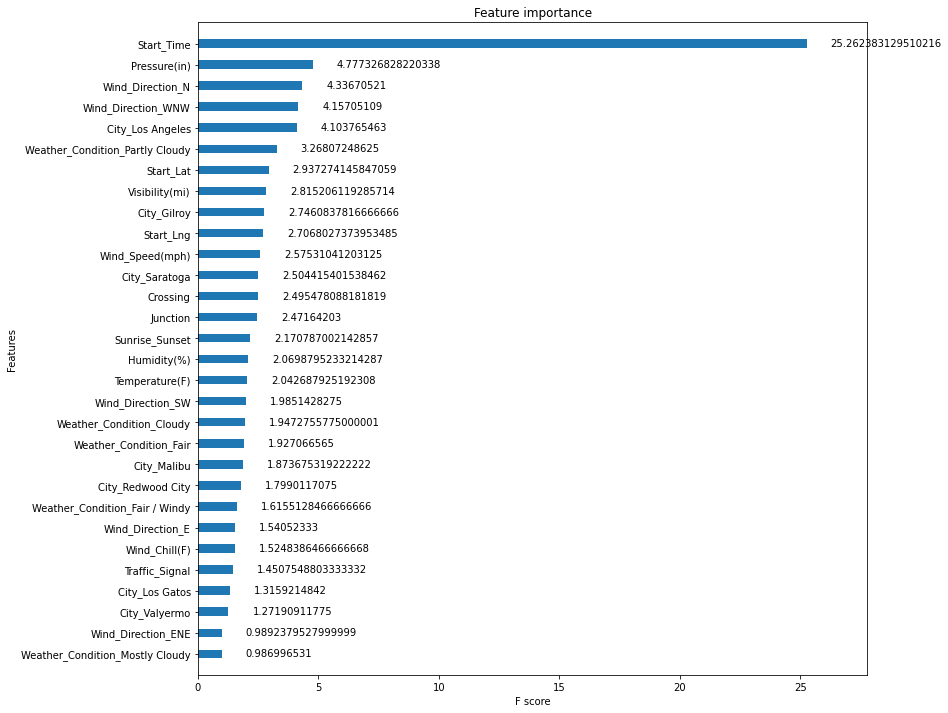

In [ ]:
ax = plot_importance(booster=xgb_model, importance_type='gain', height=0.4, grid=False)
fig = ax.figure
fig.set_size_inches(12, 12)

#Model Evaluation

In [ ]:
def create_roc_plot(name, predictions):
  auc = roc_auc_score(y_test, predictions).round(2)
  fpr, tpr, _ = roc_curve(y_test, predictions)

  plt.figure(figsize=(5, 3))
  plt.plot([0, 1], [0, 1], linestyle='--')  # plot horizontal line 
  plt.plot(fpr, tpr, label='{} AUC = {}'.format(name, auc)) # plot the roc curve for the model
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend(loc='lower right')  # show the legend
  plt.show() # show the plot
  return None

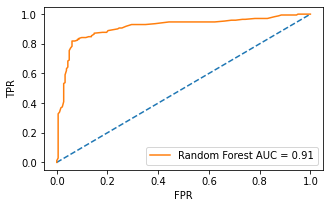

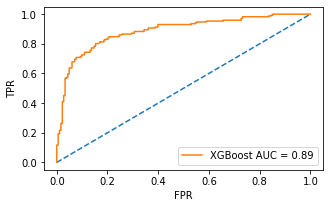

In [ ]:
create_roc_plot('Random Forest', pred_rf)
create_roc_plot('XGBoost', pred_xgb)